In [141]:
import pandas as pd
import matplotlib.dates as mdates
import seaborn as sns
from sklearn.preprocessing import LabelEncoder
import matplotlib.pyplot as plt
import numpy as np

In [142]:
#load data
df=pd.read_csv("/mnt/c/Users/PC/Downloads/paris_temperature.csv")

## data Preprocessing


In [143]:
#change datetime
df['datetime'] = pd.to_datetime(df['datetime'])
df['sunrise'] = pd.to_datetime(df['sunrise'], errors='coerce')
df['sunset'] = pd.to_datetime(df['sunset'], errors='coerce')

In [144]:
#find categorical features
categorical_features = df.select_dtypes(include=['object', 'category']).columns
print("Categorical features:", categorical_features.tolist())

Categorical features: ['name', 'preciptype', 'conditions', 'description', 'icon', 'stations']


In [145]:
#drop 3 columns that are not used
df.drop(columns=['description', 'stations', 'name','sunrise','sunset'], inplace=True)

In [146]:
#number of cells contain Nan in preciptype
#Nan_prec=df['preciptype'].isna().sum() "74 Nan cells"
#fill Nan with mode of the column
df['preciptype'].fillna("no_rain", inplace=True)

/tmp/ipykernel_9509/868927206.py:4: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df['preciptype'].fillna("no_rain", inplace=True)


In [147]:
#encoder 
label_encoders=LabelEncoder()
df['preciptype']=label_encoders.fit_transform(df['preciptype'])
df['conditions']=label_encoders.fit_transform(df['conditions'])
df['icon']=label_encoders.fit_transform(df['icon'])

## Training model with categorical features

In [159]:
#start in training data
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
import lightgbm as lgb
import xgboost as xgb
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_percentage_error 

In [149]:
#split data
x=df.drop('temp',axis=1)
y=df['temp']
x_train,x_test,y_train,y_test=train_test_split(x,y,test_size=0.2,random_state=42)

# #scale Data
# scaler=StandardScaler()
# x_train_scaled=scaler.fit_transform(x_train)
# x_test_scaled=scaler.fit_transform(x_test)

In [152]:
#scale Data
x_train_time=x_train['datetime']
x_test_time=x_test['datetime']
x_train.drop('datetime',axis=1,inplace=True)
x_test.drop('datetime',axis=1,inplace=True)
scaler=StandardScaler()
x_train_scaled=scaler.fit_transform(x_train)
x_test_scaled=scaler.fit_transform(x_test)

# linear regression

In [160]:
#linear reg
linear=LinearRegression()
param={
    'fit_intercept': [True, False]
}
grid_linear=GridSearchCV(estimator=linear, param_grid=param,cv=5, scoring='neg_mean_squared_error')

grid_linear.fit(x_train,y_train)

y_pred = grid_linear.predict(x_test)

mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)
mape = mean_absolute_percentage_error(y_test, y_pred) 
print('RMSE:', mse)
print('R2:', r2)
print('MAPE:', mape)

RMSE: 0.04656648208956753
R2: 0.9985648032578996
MAPE: 0.0403075800161505


In [163]:
y_test

280    16.8
248    17.8
218    14.2
327    21.1
56      3.8
       ... 
104    -1.2
167    12.2
63      0.8
232    16.5
84     11.1
Name: temp, Length: 77, dtype: float64

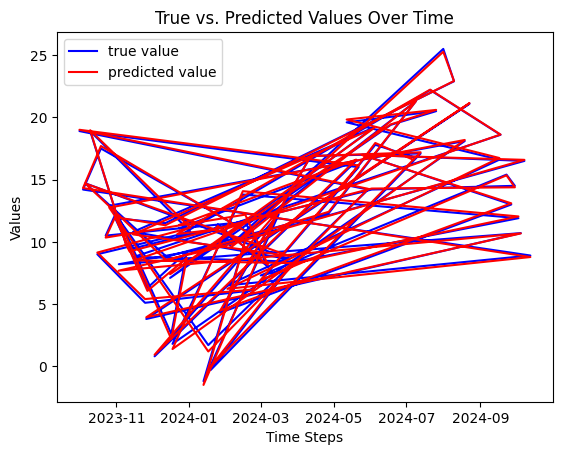

In [ ]:
plt.plot(x_test_time,y_test, label='true value',color='blue')
plt.plot(x_test_time,y_pred,label='predicted value',color='red')
plt.xlabel('Time Steps')
plt.ylabel('Values')
plt.title('True vs. Predicted Values Over Time')
# Add a legend
plt.legend()
# Show the plot
plt.show()

LOL overfit

# lgb

In [167]:
lgb_model = lgb.LGBMRegressor(n_estimators=100, learning_rate=0.05)
lgb_model.fit(x_train, y_train)
y_pred_lgb = lgb_model.predict(x_test)
print(f"LightGBM MSE: {mean_squared_error(y_test, y_pred_lgb)}")

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000086 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1479
[LightGBM] [Info] Number of data points in the train set: 305, number of used features: 23
[LightGBM] [Info] Start training from score 13.571803
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, 

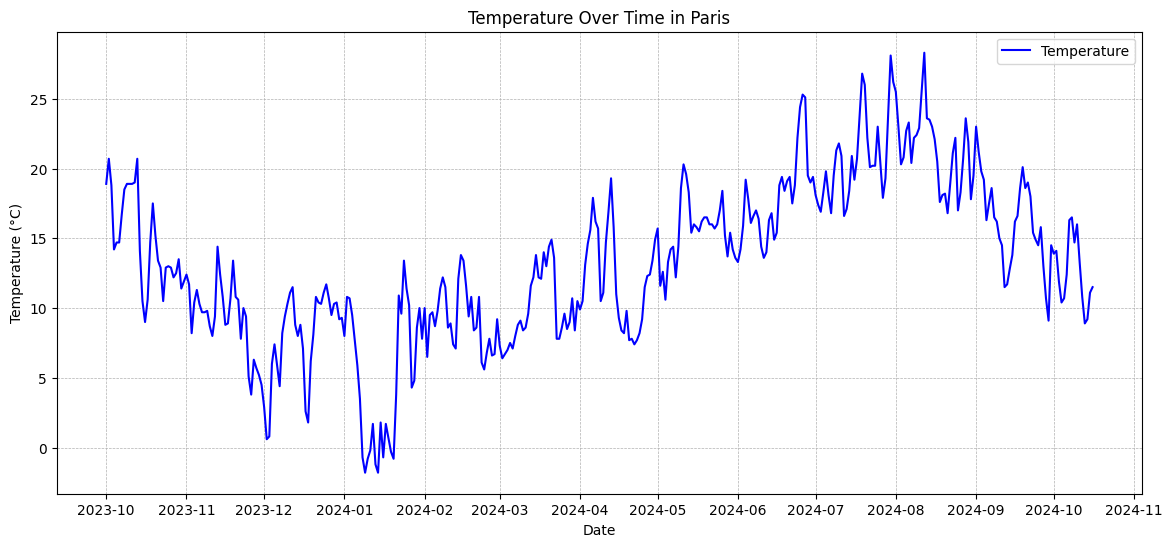

In [ ]:

# Plot the temperature ('temp') over time
plt.figure(figsize=(14, 6))
plt.plot(df['datetime'], df['temp'], label='Temperature', color='b')
plt.xlabel('Date')
plt.ylabel('Temperature (°C)')
plt.title('Temperature Over Time in Paris')

# Set x-axis to display grid lines each month
plt.gca().xaxis.set_major_locator(mdates.MonthLocator())
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))
plt.grid(visible=True, which='major', linestyle='--', linewidth=0.5)

plt.legend()
plt.show()